# ICPHM23 Data Challenge - Detecção de Falhas em Engrenagens Planetárias

## 1. Introdução

Este projeto é baseado no **ICPHM23 Data Challenge** sobre monitoramento da saúde de sistemas industriais usando análise de sinais de vibração.

### Objetivo
Desenvolver modelos de Machine Learning para classificar 5 condições diferentes de uma engrenagem solar:
1. **Normal** (0)
2. **Desgaste Superficial** - Surface Wear (1)
3. **Rachadura** - Crack (2)
4. **Lascado** - Chipped (3)
5. **Dente Faltando** - Tooth Missing (4)

### Especificações dos Dados
- **Sinais de vibração** em 3 direções (x, y, z)
- **Segmentos** de 200 pontos de dados
- **2 condições operacionais**:
  - Exp. 1: 1500 rpm, 10 Nm
  - Exp. 2: 2700 rpm, 25 Nm
- **Frequência de amostragem**: 10 kHz
- **Validação**: 5-fold cross-validation

## 2. Importação de Bibliotecas

In [39]:
# Operações básicas
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# Processamento de sinais
from scipy import stats
from scipy.fft import fft, fftfreq
from scipy.signal import welch

# Machine Learning
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)

# Modelos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 3. Carregamento dos Dados

In [40]:
# Definir caminhos dos dados
path_1500 = 'Rotação 1500/'
path_2700 = 'Rotação 2700/'

# Carregar dados da condição 1 (1500 rpm, 10 Nm)
print("Carregando dados da Condição 1 (1500 rpm, 10 Nm)...")
x_1500 = np.load(os.path.join(path_1500, 'x_1500_10.npy'))
y_1500 = np.load(os.path.join(path_1500, 'y_1500_10.npy'))
z_1500 = np.load(os.path.join(path_1500, 'z_1500_10.npy'))
gt_1500 = np.load(os.path.join(path_1500, 'gt_1500_10.npy'))

print(f"Shape X: {x_1500.shape}")
print(f"Shape Y: {y_1500.shape}")
print(f"Shape Z: {z_1500.shape}")
print(f"Shape GT: {gt_1500.shape}")
print(f"Classes únicas: {np.unique(gt_1500)}")

# Carregar dados da condição 2 (2700 rpm, 25 Nm)
print("\nCarregando dados da Condição 2 (2700 rpm, 25 Nm)...")
x_2700 = np.load(os.path.join(path_2700, 'x_2700_25.npy'))
y_2700 = np.load(os.path.join(path_2700, 'y_2700_25.npy'))
z_2700 = np.load(os.path.join(path_2700, 'z_2700_25.npy'))
gt_2700 = np.load(os.path.join(path_2700, 'gt_2700_25.npy'))

print(f"Shape X: {x_2700.shape}")
print(f"Shape Y: {y_2700.shape}")
print(f"Shape Z: {z_2700.shape}")
print(f"Shape GT: {gt_2700.shape}")
print(f"Classes únicas: {np.unique(gt_2700)}")

Carregando dados da Condição 1 (1500 rpm, 10 Nm)...
Shape X: (50000, 200)
Shape Y: (50000, 200)
Shape Z: (50000, 200)
Shape GT: (50000,)
Classes únicas: [0 1 2 3 4]

Carregando dados da Condição 2 (2700 rpm, 25 Nm)...
Shape X: (50000, 200)
Shape Y: (50000, 200)
Shape Z: (50000, 200)
Shape GT: (50000,)
Classes únicas: [0 1 2 3 4]


## 4. Análise Exploratória dos Dados (EDA)

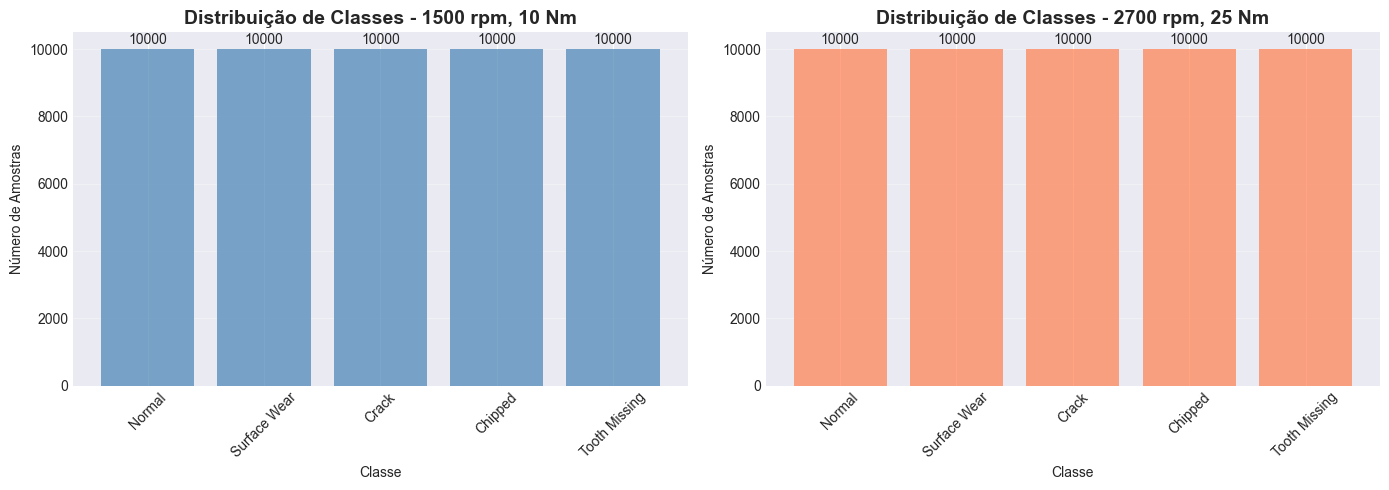


ESTATÍSTICAS DOS DADOS

Condição 1 (1500 rpm, 10 Nm):
  Total de amostras: 50000
  Tamanho de cada segmento: 200 pontos
  Normal: 10000 amostras (20.0%)
  Surface Wear: 10000 amostras (20.0%)
  Crack: 10000 amostras (20.0%)
  Chipped: 10000 amostras (20.0%)
  Tooth Missing: 10000 amostras (20.0%)

Condição 2 (2700 rpm, 25 Nm):
  Total de amostras: 50000
  Tamanho de cada segmento: 200 pontos
  Normal: 10000 amostras (20.0%)
  Surface Wear: 10000 amostras (20.0%)
  Crack: 10000 amostras (20.0%)
  Chipped: 10000 amostras (20.0%)
  Tooth Missing: 10000 amostras (20.0%)


In [41]:
# Mapear labels para nomes das classes
class_names = {
    0: 'Normal',
    1: 'Surface Wear',
    2: 'Crack',
    3: 'Chipped',
    4: 'Tooth Missing'
}

# Distribuição de classes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Condição 1500 rpm
unique_1500, counts_1500 = np.unique(gt_1500, return_counts=True)
labels_1500 = [class_names[i] for i in unique_1500]
axes[0].bar(labels_1500, counts_1500, color='steelblue', alpha=0.7)
axes[0].set_title('Distribuição de Classes - 1500 rpm, 10 Nm', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Número de Amostras')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(counts_1500):
    axes[0].text(i, v + 50, str(v), ha='center', va='bottom')

# Condição 2700 rpm
unique_2700, counts_2700 = np.unique(gt_2700, return_counts=True)
labels_2700 = [class_names[i] for i in unique_2700]
axes[1].bar(labels_2700, counts_2700, color='coral', alpha=0.7)
axes[1].set_title('Distribuição de Classes - 2700 rpm, 25 Nm', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Número de Amostras')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(counts_2700):
    axes[1].text(i, v + 50, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Estatísticas
print("\n" + "="*60)
print("ESTATÍSTICAS DOS DADOS")
print("="*60)
print(f"\nCondição 1 (1500 rpm, 10 Nm):")
print(f"  Total de amostras: {len(gt_1500)}")
print(f"  Tamanho de cada segmento: {x_1500.shape[1]} pontos")
for label, count in zip(unique_1500, counts_1500):
    print(f"  {class_names[label]}: {count} amostras ({count/len(gt_1500)*100:.1f}%)")

print(f"\nCondição 2 (2700 rpm, 25 Nm):")
print(f"  Total de amostras: {len(gt_2700)}")
print(f"  Tamanho de cada segmento: {x_2700.shape[1]} pontos")
for label, count in zip(unique_2700, counts_2700):
    print(f"  {class_names[label]}: {count} amostras ({count/len(gt_2700)*100:.1f}%)")

## 5. Visualização dos Sinais no Domínio do Tempo

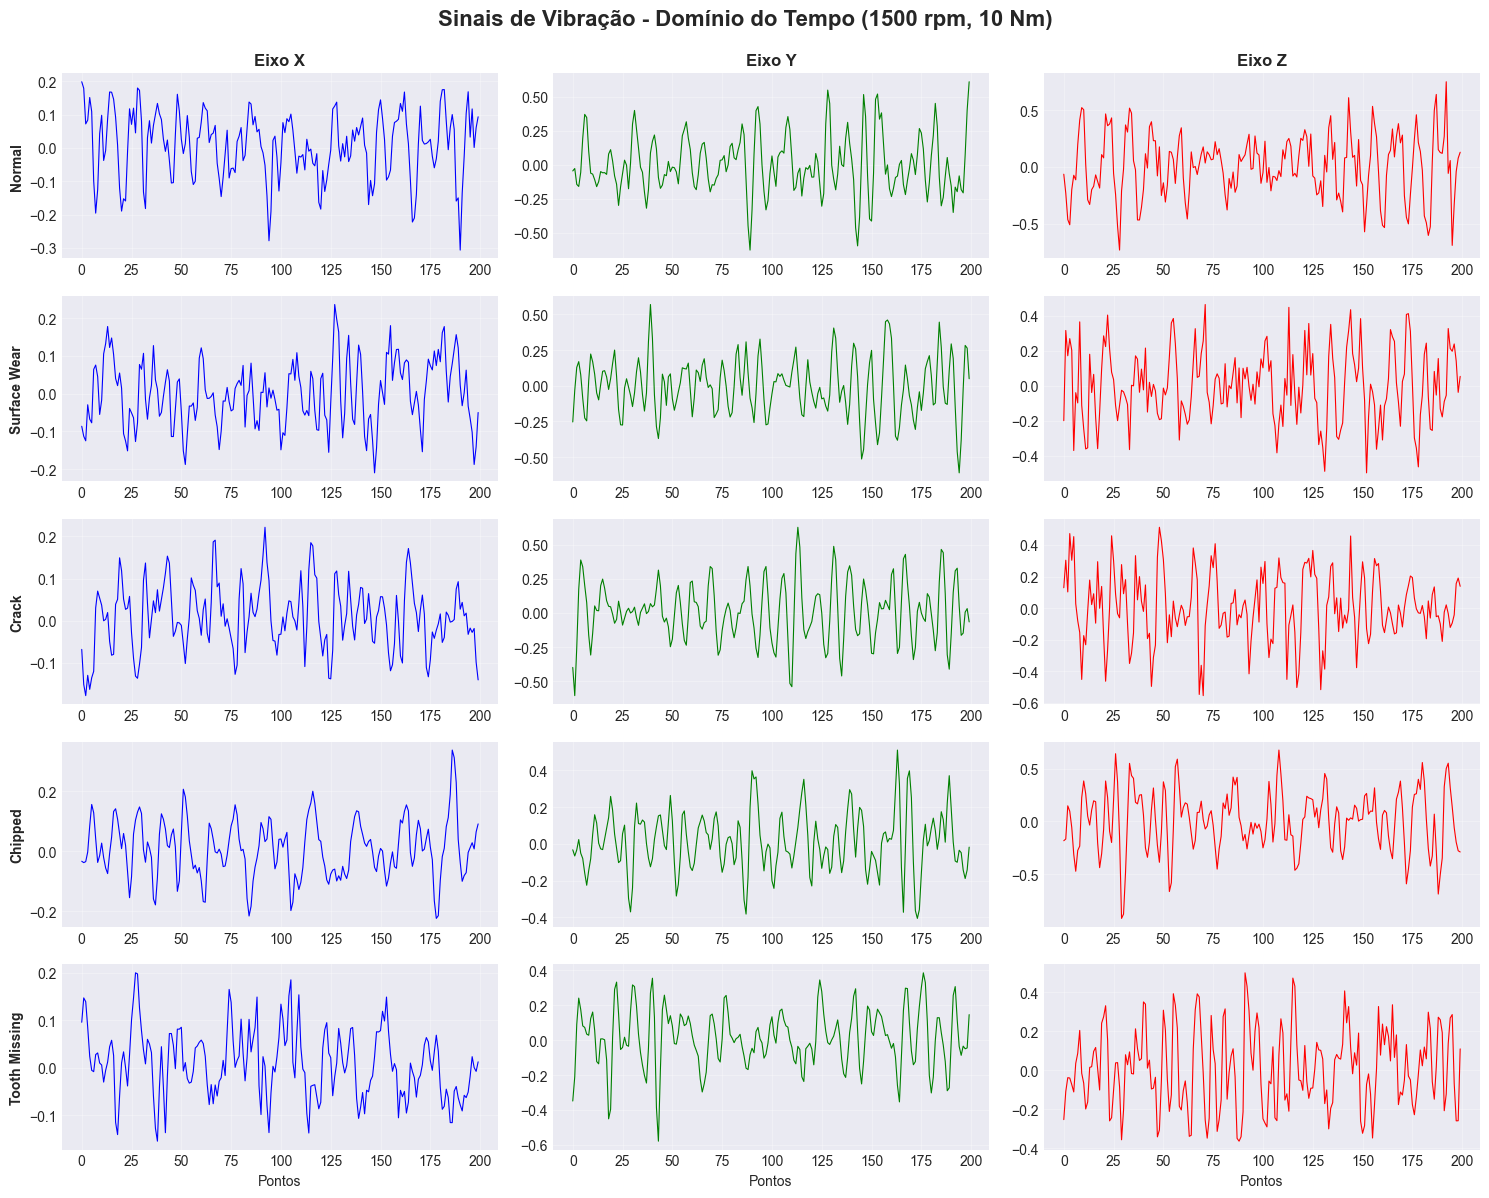

In [42]:
# Visualizar exemplos de sinais para cada classe (Condição 1500 rpm)
fig, axes = plt.subplots(5, 3, figsize=(15, 12))
fig.suptitle('Sinais de Vibração - Domínio do Tempo (1500 rpm, 10 Nm)', 
             fontsize=16, fontweight='bold', y=0.995)

for class_idx in range(5):
    # Encontrar primeira amostra da classe
    sample_idx = np.where(gt_1500 == class_idx)[0][0]
    
    # Plot X
    axes[class_idx, 0].plot(x_1500[sample_idx], linewidth=0.8, color='blue')
    axes[class_idx, 0].set_ylabel(class_names[class_idx], fontweight='bold')
    axes[class_idx, 0].grid(alpha=0.3)
    if class_idx == 0:
        axes[class_idx, 0].set_title('Eixo X', fontweight='bold')
    if class_idx == 4:
        axes[class_idx, 0].set_xlabel('Pontos')
    
    # Plot Y
    axes[class_idx, 1].plot(y_1500[sample_idx], linewidth=0.8, color='green')
    axes[class_idx, 1].grid(alpha=0.3)
    if class_idx == 0:
        axes[class_idx, 1].set_title('Eixo Y', fontweight='bold')
    if class_idx == 4:
        axes[class_idx, 1].set_xlabel('Pontos')
    
    # Plot Z
    axes[class_idx, 2].plot(z_1500[sample_idx], linewidth=0.8, color='red')
    axes[class_idx, 2].grid(alpha=0.3)
    if class_idx == 0:
        axes[class_idx, 2].set_title('Eixo Z', fontweight='bold')
    if class_idx == 4:
        axes[class_idx, 2].set_xlabel('Pontos')

plt.tight_layout()
plt.show()

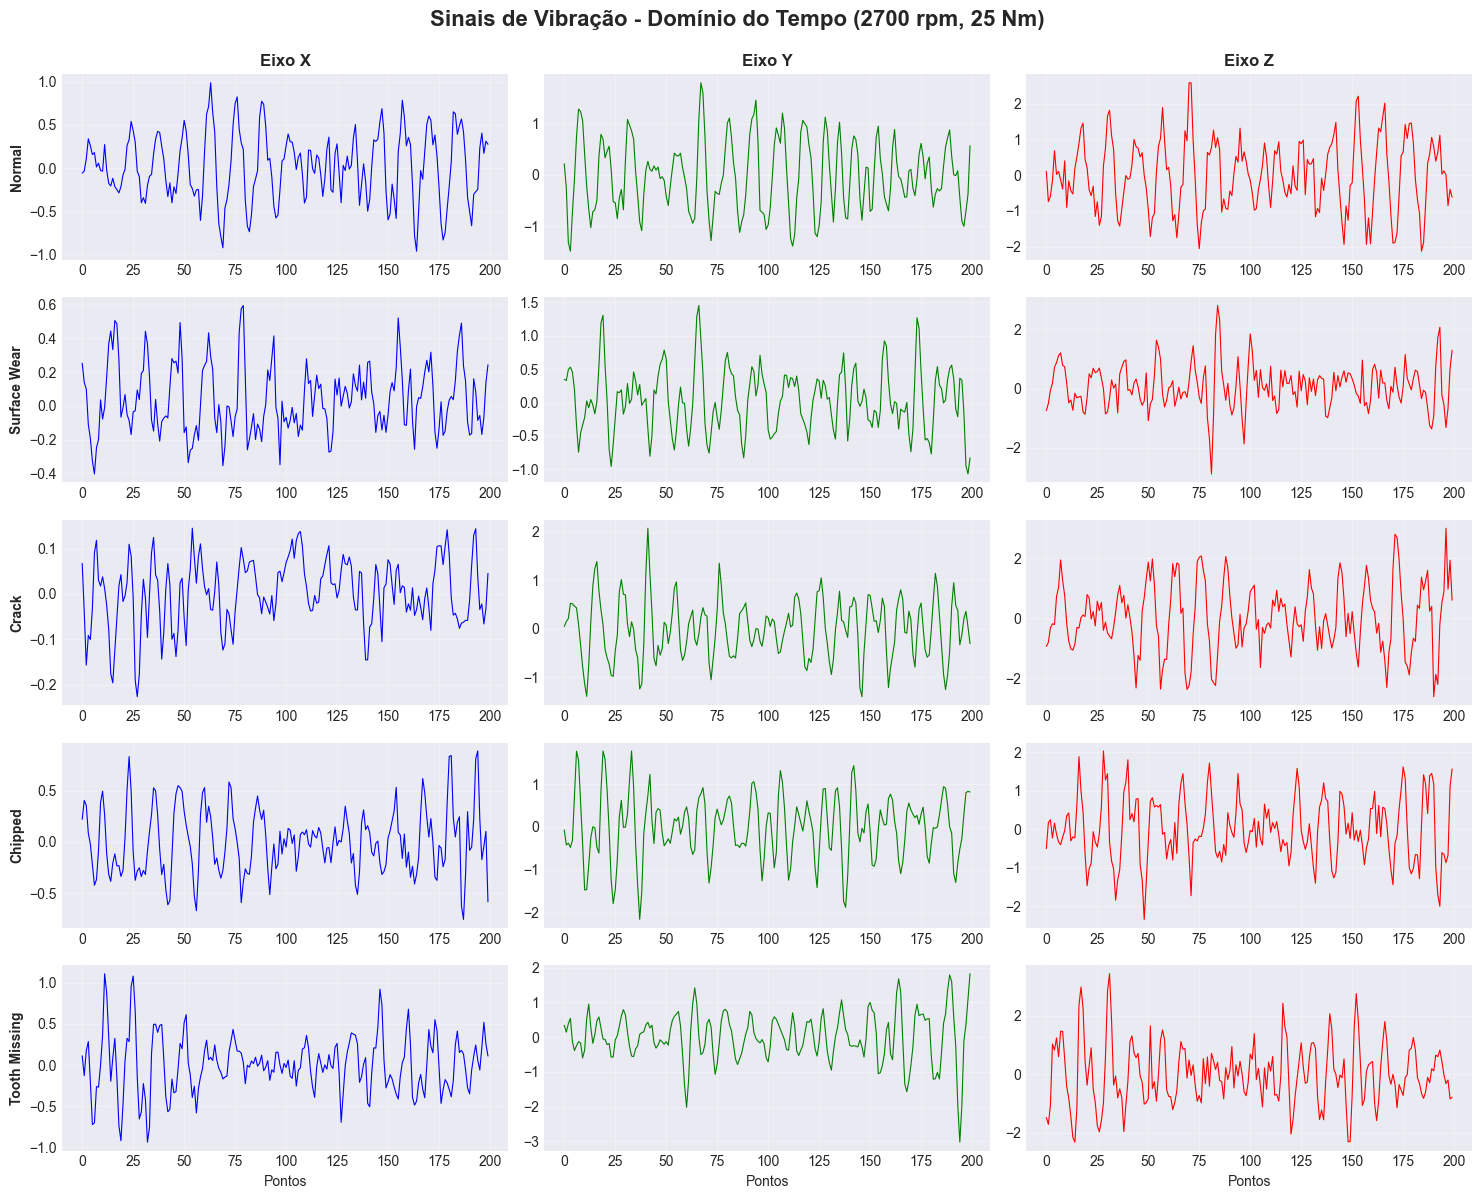

In [43]:
# Visualizar exemplos de sinais para cada classe (Condição 2700 rpm)
fig, axes = plt.subplots(5, 3, figsize=(15, 12))
fig.suptitle('Sinais de Vibração - Domínio do Tempo (2700 rpm, 25 Nm)', 
             fontsize=16, fontweight='bold', y=0.995)

for class_idx in range(5):
    # Encontrar primeira amostra da classe
    sample_idx = np.where(gt_2700 == class_idx)[0][0]
    
    # Plot X
    axes[class_idx, 0].plot(x_2700[sample_idx], linewidth=0.8, color='blue')
    axes[class_idx, 0].set_ylabel(class_names[class_idx], fontweight='bold')
    axes[class_idx, 0].grid(alpha=0.3)
    if class_idx == 0:
        axes[class_idx, 0].set_title('Eixo X', fontweight='bold')
    if class_idx == 4:
        axes[class_idx, 0].set_xlabel('Pontos')
    
    # Plot Y
    axes[class_idx, 1].plot(y_2700[sample_idx], linewidth=0.8, color='green')
    axes[class_idx, 1].grid(alpha=0.3)
    if class_idx == 0:
        axes[class_idx, 1].set_title('Eixo Y', fontweight='bold')
    if class_idx == 4:
        axes[class_idx, 1].set_xlabel('Pontos')
    
    # Plot Z
    axes[class_idx, 2].plot(z_2700[sample_idx], linewidth=0.8, color='red')
    axes[class_idx, 2].grid(alpha=0.3)
    if class_idx == 0:
        axes[class_idx, 2].set_title('Eixo Z', fontweight='bold')
    if class_idx == 4:
        axes[class_idx, 2].set_xlabel('Pontos')

plt.tight_layout()
plt.show()

## 6. Análise no Domínio da Frequência (FFT)

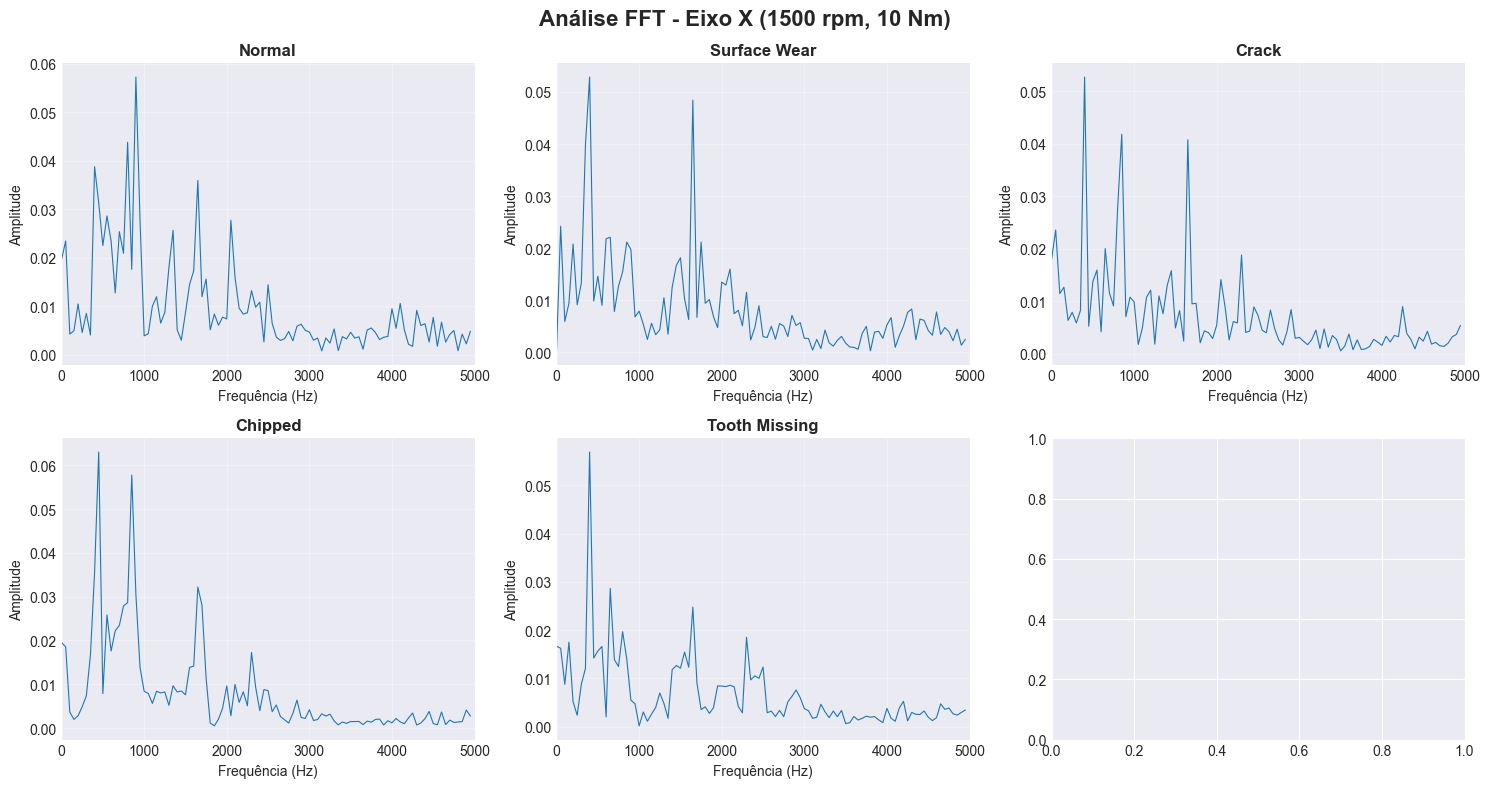

In [44]:
def plot_fft(signal, sampling_freq=10000, title='FFT'):
    """Calcula e plota a FFT de um sinal"""
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1/sampling_freq)[:N//2]
    
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid(alpha=0.3)

# FFT para cada classe (1500 rpm, usando eixo X)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Análise FFT - Eixo X (1500 rpm, 10 Nm)', fontsize=16, fontweight='bold')

for i, class_idx in enumerate([0, 1, 2, 3, 4]):
    if i < 5:
        row = i // 3
        col = i % 3
        plt.subplot(2, 3, i+1)
        
        sample_idx = np.where(gt_1500 == class_idx)[0][0]
        signal = x_1500[sample_idx]
        
        N = len(signal)
        yf = fft(signal)
        xf = fftfreq(N, 1/10000)[:N//2]
        
        plt.plot(xf, 2.0/N * np.abs(yf[:N//2]), linewidth=0.8)
        plt.xlabel('Frequência (Hz)')
        plt.ylabel('Amplitude')
        plt.title(class_names[class_idx], fontweight='bold')
        plt.grid(alpha=0.3)
        plt.xlim([0, 5000])  # Limitar até 5kHz para melhor visualização

plt.tight_layout()
plt.show()

## 7. Extração de Features

Vamos extrair features estatísticas e no domínio da frequência para cada segmento de sinal.

In [45]:
def extract_time_features(signal):
    """Extrai features estatísticas no domínio do tempo"""
    features = []
    
    # Features básicas
    features.append(np.mean(signal))           # Média
    features.append(np.std(signal))            # Desvio padrão
    features.append(np.var(signal))            # Variância
    features.append(np.max(signal))            # Valor máximo
    features.append(np.min(signal))            # Valor mínimo
    features.append(np.ptp(signal))            # Peak-to-peak
    features.append(np.median(signal))         # Mediana
    
    # RMS (Root Mean Square)
    features.append(np.sqrt(np.mean(signal**2)))
    
    # Skewness e Kurtosis
    features.append(stats.skew(signal))        # Assimetria
    features.append(stats.kurtosis(signal))    # Curtose
    
    # Crest Factor
    rms = np.sqrt(np.mean(signal**2))
    if rms != 0:
        features.append(np.max(np.abs(signal)) / rms)
    else:
        features.append(0)
    
    # Shape Factor
    mean_abs = np.mean(np.abs(signal))
    if mean_abs != 0:
        features.append(rms / mean_abs)
    else:
        features.append(0)
    
    # Impulse Factor
    if mean_abs != 0:
        features.append(np.max(np.abs(signal)) / mean_abs)
    else:
        features.append(0)
    
    return features


def extract_frequency_features(signal, sampling_freq=10000):
    """Extrai features no domínio da frequência"""
    features = []
    
    # FFT
    N = len(signal)
    yf = np.abs(fft(signal)[:N//2])
    xf = fftfreq(N, 1/sampling_freq)[:N//2]
    
    # Frequência dominante
    dominant_freq_idx = np.argmax(yf)
    features.append(xf[dominant_freq_idx])
    
    # Magnitude da frequência dominante
    features.append(yf[dominant_freq_idx])
    
    # Energia espectral
    features.append(np.sum(yf**2))
    
    # Centróide espectral
    if np.sum(yf) != 0:
        features.append(np.sum(xf * yf) / np.sum(yf))
    else:
        features.append(0)
    
    # Banda de frequência média
    features.append(np.mean(yf))
    
    return features


def extract_all_features(x, y, z):
    """Extrai todas as features dos 3 eixos"""
    features = []
    
    # Features para cada eixo
    for signal in [x, y, z]:
        features.extend(extract_time_features(signal))
        features.extend(extract_frequency_features(signal))
    
    # Features da magnitude combinada
    magnitude = np.sqrt(x**2 + y**2 + z**2)
    features.extend(extract_time_features(magnitude))
    features.extend(extract_frequency_features(magnitude))
    
    return features


print("Funções de extração de features definidas!")
print(f"\nNúmero de features por eixo (tempo): 13")
print(f"Número de features por eixo (frequência): 5")
print(f"Total de features por eixo: 18")
print(f"Total de features (3 eixos + magnitude): 72")

Funções de extração de features definidas!

Número de features por eixo (tempo): 13
Número de features por eixo (frequência): 5
Total de features por eixo: 18
Total de features (3 eixos + magnitude): 72


In [46]:
# Extrair features para a condição 1 (1500 rpm)
print("Extraindo features para a Condição 1 (1500 rpm, 10 Nm)...")
features_1500 = []

for i in range(len(gt_1500)):
    features = extract_all_features(x_1500[i], y_1500[i], z_1500[i])
    features_1500.append(features)
    
    if (i + 1) % 500 == 0:
        print(f"  Processadas {i+1}/{len(gt_1500)} amostras")

features_1500 = np.array(features_1500)
print(f"✓ Shape das features (1500 rpm): {features_1500.shape}")

# Extrair features para a condição 2 (2700 rpm)
print("\nExtraindo features para a Condição 2 (2700 rpm, 25 Nm)...")
features_2700 = []

for i in range(len(gt_2700)):
    features = extract_all_features(x_2700[i], y_2700[i], z_2700[i])
    features_2700.append(features)
    
    if (i + 1) % 500 == 0:
        print(f"  Processadas {i+1}/{len(gt_2700)} amostras")

features_2700 = np.array(features_2700)
print(f"✓ Shape das features (2700 rpm): {features_2700.shape}")

Extraindo features para a Condição 1 (1500 rpm, 10 Nm)...
  Processadas 500/50000 amostras
  Processadas 1000/50000 amostras
  Processadas 1500/50000 amostras
  Processadas 2000/50000 amostras
  Processadas 2500/50000 amostras
  Processadas 3000/50000 amostras
  Processadas 3500/50000 amostras
  Processadas 4000/50000 amostras
  Processadas 4500/50000 amostras
  Processadas 5000/50000 amostras
  Processadas 5500/50000 amostras
  Processadas 6000/50000 amostras
  Processadas 6500/50000 amostras
  Processadas 7000/50000 amostras
  Processadas 7500/50000 amostras
  Processadas 8000/50000 amostras
  Processadas 8500/50000 amostras
  Processadas 9000/50000 amostras
  Processadas 9500/50000 amostras
  Processadas 10000/50000 amostras
  Processadas 10500/50000 amostras
  Processadas 11000/50000 amostras
  Processadas 11500/50000 amostras
  Processadas 12000/50000 amostras
  Processadas 12500/50000 amostras
  Processadas 13000/50000 amostras
  Processadas 13500/50000 amostras
  Processadas 140

## 9.  Dica do professor

In [47]:
# FFT (x, y, z) -> PCA -> concat com features atuais
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def fft_xyz_features(x, y, z, n_freq=100):
    fx = np.abs(np.fft.rfft(x))[:n_freq]
    fy = np.abs(np.fft.rfft(y))[:n_freq]
    fz = np.abs(np.fft.rfft(z))[:n_freq]
    return np.concatenate([fx, fy, fz])

# Condição 1500
fft_feats_1500 = np.array([fft_xyz_features(x_1500[i], y_1500[i], z_1500[i]) for i in range(len(gt_1500))])
fft_scaler_1500 = StandardScaler()
fft_feats_1500_scaled = fft_scaler_1500.fit_transform(fft_feats_1500)
pca_1500 = PCA(n_components=0.95, random_state=42)
fft_pca_1500 = pca_1500.fit_transform(fft_feats_1500_scaled)

# Condição 2700
fft_feats_2700 = np.array([fft_xyz_features(x_2700[i], y_2700[i], z_2700[i]) for i in range(len(gt_2700))])
fft_scaler_2700 = StandardScaler()
fft_feats_2700_scaled = fft_scaler_2700.fit_transform(fft_feats_2700)
pca_2700 = PCA(n_components=0.95, random_state=42)
fft_pca_2700 = pca_2700.fit_transform(fft_feats_2700_scaled)

# Concatena com features já extraídas no seu notebook
features_1500 = np.hstack([features_1500, fft_pca_1500])
features_2700 = np.hstack([features_2700, fft_pca_2700])

# ===== Nomes das features (base + PCA) =====
time_features = ['mean', 'std', 'var', 'max', 'min', 'ptp', 'median', 'rms',
                 'skew', 'kurtosis', 'crest', 'shape', 'impulse']
freq_features = ['dom_freq', 'dom_mag', 'energy', 'centroid', 'mean_band']
axes_names = ['X', 'Y', 'Z', 'Magnitude']

base_feature_names = []
for axis in axes_names:
    for feat in time_features:
        base_feature_names.append(f"{axis}_{feat}")
    for feat in freq_features:
        base_feature_names.append(f"{axis}_{feat}")

pca_feature_names_1500 = [f"PCA_FFT_{i+1}" for i in range(fft_pca_1500.shape[1])]
pca_feature_names_2700 = [f"PCA_FFT_{i+1}" for i in range(fft_pca_2700.shape[1])]

feature_names_1500 = base_feature_names + pca_feature_names_1500
feature_names_2700 = base_feature_names + pca_feature_names_2700

print("Novo shape 1500:", features_1500.shape, "| componentes PCA:", fft_pca_1500.shape[1])
print("Novo shape 2700:", features_2700.shape, "| componentes PCA:", fft_pca_2700.shape[1])

Novo shape 1500: (50000, 313) | componentes PCA: 241
Novo shape 2700: (50000, 313) | componentes PCA: 241


## 8. Normalização das Features

In [48]:
# Normalizar features usando StandardScaler
scaler_1500 = StandardScaler()
scaler_2700 = StandardScaler()

features_1500_scaled = scaler_1500.fit_transform(features_1500)
features_2700_scaled = scaler_2700.fit_transform(features_2700)

print("✓ Features normalizadas com sucesso!")
print(f"\nCondição 1 - Média antes da normalização: {np.mean(features_1500):.3f}")
print(f"Condição 1 - Média após normalização: {np.mean(features_1500_scaled):.3e}")
print(f"\nCondição 2 - Média antes da normalização: {np.mean(features_2700):.3f}")
print(f"Condição 2 - Média após normalização: {np.mean(features_2700_scaled):.3e}")

✓ Features normalizadas com sucesso!

Condição 1 - Média antes da normalização: 46.762
Condição 1 - Média após normalização: -2.019e-15

Condição 2 - Média antes da normalização: 316.069
Condição 2 - Média após normalização: -1.106e-15


## 9. Treinamento e Avaliação dos Modelos

Vamos treinar múltiplos modelos de Machine Learning usando validação cruzada de 5 folds.

In [49]:
# Definir modelos para avaliação
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Configurar cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Métricas para avaliar
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

print("="*70)
print("MODELOS CONFIGURADOS")
print("="*70)
for name in models.keys():
    print(f"  ✓ {name}")
print(f"\n✓ Validação Cruzada: 5-Fold Stratified")
print(f"✓ Métricas: Accuracy, Precision, Recall, F1-Score")

MODELOS CONFIGURADOS
  ✓ Random Forest
  ✓ Gradient Boosting
  ✓ SVM
  ✓ KNN
  ✓ Decision Tree

✓ Validação Cruzada: 5-Fold Stratified
✓ Métricas: Accuracy, Precision, Recall, F1-Score


### 9.1. Avaliação - Condição 1 (1500 rpm, 10 Nm)

In [50]:
print("="*70)
print("AVALIAÇÃO - CONDIÇÃO 1 (1500 rpm, 10 Nm)")
print("="*70)

results_1500 = {}

for name, model in models.items():
    print(f"\nTreinando {name}...")
    
    # Cross-validation
    cv_results = cross_validate(
        model, features_1500_scaled, gt_1500,
        cv=cv, scoring=scoring, n_jobs=-1
    )
    
    # Armazenar resultados
    results_1500[name] = {
        'accuracy': cv_results['test_accuracy'].mean(),
        'precision': cv_results['test_precision_macro'].mean(),
        'recall': cv_results['test_recall_macro'].mean(),
        'f1': cv_results['test_f1_macro'].mean(),
        'accuracy_std': cv_results['test_accuracy'].std()
    }
    
    print(f"  Accuracy:  {results_1500[name]['accuracy']:.4f} (±{results_1500[name]['accuracy_std']:.4f})")
    print(f"  Precision: {results_1500[name]['precision']:.4f}")
    print(f"  Recall:    {results_1500[name]['recall']:.4f}")
    print(f"  F1-Score:  {results_1500[name]['f1']:.4f}")

print("\n" + "="*70)
print("✓ Avaliação da Condição 1 concluída!")
print("="*70)

AVALIAÇÃO - CONDIÇÃO 1 (1500 rpm, 10 Nm)

Treinando Random Forest...
  Accuracy:  0.8846 (±0.0010)
  Precision: 0.8839
  Recall:    0.8846
  F1-Score:  0.8841

Treinando Gradient Boosting...
  Accuracy:  0.9049 (±0.0008)
  Precision: 0.9050
  Recall:    0.9049
  F1-Score:  0.9050

Treinando SVM...
  Accuracy:  0.9751 (±0.0006)
  Precision: 0.9753
  Recall:    0.9751
  F1-Score:  0.9752

Treinando KNN...
  Accuracy:  0.9344 (±0.0009)
  Precision: 0.9410
  Recall:    0.9344
  F1-Score:  0.9352

Treinando Decision Tree...
  Accuracy:  0.7415 (±0.0037)
  Precision: 0.7421
  Recall:    0.7415
  F1-Score:  0.7418

✓ Avaliação da Condição 1 concluída!


### 9.2. Avaliação - Condição 2 (2700 rpm, 25 Nm)

In [51]:
print("="*70)
print("AVALIAÇÃO - CONDIÇÃO 2 (2700 rpm, 25 Nm)")
print("="*70)

results_2700 = {}

for name, model in models.items():
    print(f"\nTreinando {name}...")
    
    # Cross-validation
    cv_results = cross_validate(
        model, features_2700_scaled, gt_2700,
        cv=cv, scoring=scoring, n_jobs=-1
    )
    
    # Armazenar resultados
    results_2700[name] = {
        'accuracy': cv_results['test_accuracy'].mean(),
        'precision': cv_results['test_precision_macro'].mean(),
        'recall': cv_results['test_recall_macro'].mean(),
        'f1': cv_results['test_f1_macro'].mean(),
        'accuracy_std': cv_results['test_accuracy'].std()
    }
    
    print(f"  Accuracy:  {results_2700[name]['accuracy']:.4f} (±{results_2700[name]['accuracy_std']:.4f})")
    print(f"  Precision: {results_2700[name]['precision']:.4f}")
    print(f"  Recall:    {results_2700[name]['recall']:.4f}")
    print(f"  F1-Score:  {results_2700[name]['f1']:.4f}")

print("\n" + "="*70)
print("✓ Avaliação da Condição 2 concluída!")
print("="*70)

AVALIAÇÃO - CONDIÇÃO 2 (2700 rpm, 25 Nm)

Treinando Random Forest...
  Accuracy:  0.9032 (±0.0023)
  Precision: 0.9029
  Recall:    0.9032
  F1-Score:  0.9027

Treinando Gradient Boosting...
  Accuracy:  0.9163 (±0.0038)
  Precision: 0.9164
  Recall:    0.9163
  F1-Score:  0.9162

Treinando SVM...
  Accuracy:  0.9703 (±0.0018)
  Precision: 0.9704
  Recall:    0.9703
  F1-Score:  0.9703

Treinando KNN...
  Accuracy:  0.9544 (±0.0018)
  Precision: 0.9546
  Recall:    0.9544
  F1-Score:  0.9544

Treinando Decision Tree...
  Accuracy:  0.7876 (±0.0054)
  Precision: 0.7879
  Recall:    0.7876
  F1-Score:  0.7877

✓ Avaliação da Condição 2 concluída!


## 10. Comparação de Resultados

In [52]:
# Criar DataFrame com os resultados
df_results_1500 = pd.DataFrame(results_1500).T
df_results_2700 = pd.DataFrame(results_2700).T

print("="*70)
print("RESULTADOS - CONDIÇÃO 1 (1500 rpm, 10 Nm)")
print("="*70)
print(df_results_1500.round(4))

print("\n" + "="*70)
print("RESULTADOS - CONDIÇÃO 2 (2700 rpm, 25 Nm)")
print("="*70)
print(df_results_2700.round(4))

# Identificar melhores modelos
best_model_1500 = df_results_1500['accuracy'].idxmax()
best_model_2700 = df_results_2700['accuracy'].idxmax()

print("\n" + "="*70)
print("MELHORES MODELOS")
print("="*70)
print(f"Condição 1: {best_model_1500} ({df_results_1500.loc[best_model_1500, 'accuracy']:.4f})")
print(f"Condição 2: {best_model_2700} ({df_results_2700.loc[best_model_2700, 'accuracy']:.4f})")

RESULTADOS - CONDIÇÃO 1 (1500 rpm, 10 Nm)
                   accuracy  precision  recall      f1  accuracy_std
Random Forest        0.8846     0.8839  0.8846  0.8841        0.0010
Gradient Boosting    0.9049     0.9050  0.9049  0.9050        0.0008
SVM                  0.9751     0.9753  0.9751  0.9752        0.0006
KNN                  0.9344     0.9410  0.9344  0.9352        0.0009
Decision Tree        0.7415     0.7421  0.7415  0.7418        0.0037

RESULTADOS - CONDIÇÃO 2 (2700 rpm, 25 Nm)
                   accuracy  precision  recall      f1  accuracy_std
Random Forest        0.9032     0.9029  0.9032  0.9027        0.0023
Gradient Boosting    0.9163     0.9164  0.9163  0.9162        0.0038
SVM                  0.9703     0.9704  0.9703  0.9703        0.0018
KNN                  0.9544     0.9546  0.9544  0.9544        0.0018
Decision Tree        0.7876     0.7879  0.7876  0.7877        0.0054

MELHORES MODELOS
Condição 1: SVM (0.9751)
Condição 2: SVM (0.9703)


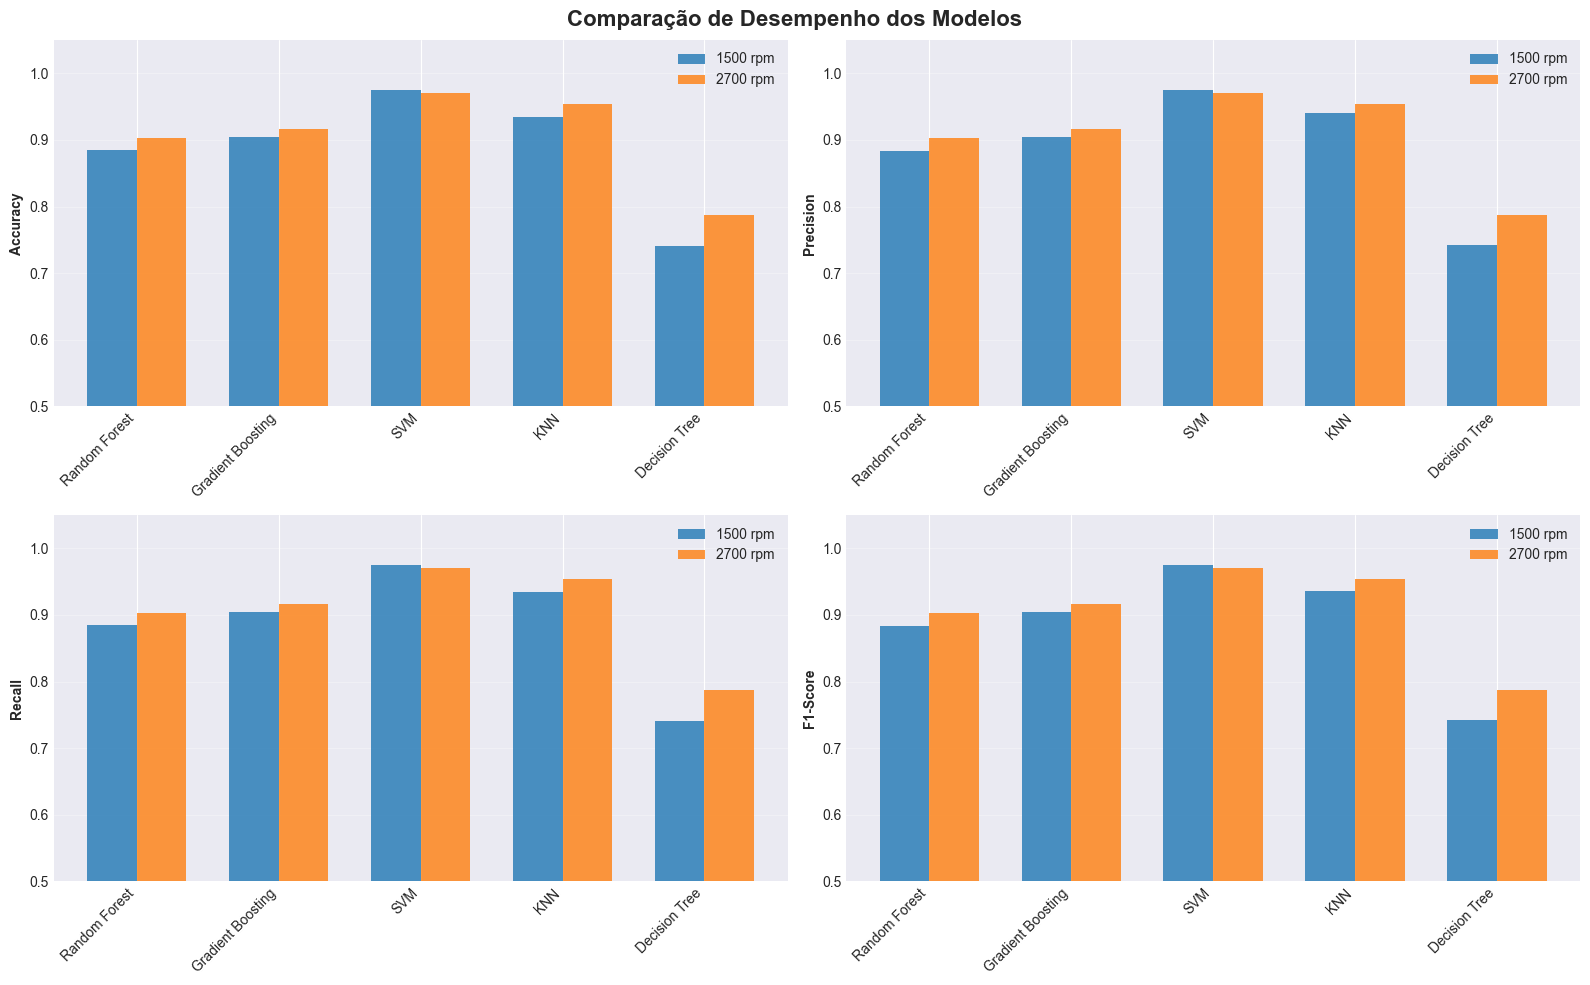

In [53]:
# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Comparação de Desempenho dos Modelos', fontsize=16, fontweight='bold')

metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    row = idx // 2
    col = idx % 2
    
    x = np.arange(len(models))
    width = 0.35
    
    values_1500 = [results_1500[name][metric] for name in models.keys()]
    values_2700 = [results_2700[name][metric] for name in models.keys()]
    
    axes[row, col].bar(x - width/2, values_1500, width, label='1500 rpm', alpha=0.8)
    axes[row, col].bar(x + width/2, values_2700, width, label='2700 rpm', alpha=0.8)
    
    axes[row, col].set_ylabel(metric_name, fontweight='bold')
    axes[row, col].set_xticks(x)
    axes[row, col].set_xticklabels(models.keys(), rotation=45, ha='right')
    axes[row, col].legend()
    axes[row, col].grid(axis='y', alpha=0.3)
    axes[row, col].set_ylim([0.5, 1.05])

plt.tight_layout()
plt.show()

## 11. Análise Detalhada do Melhor Modelo

Vamos treinar o melhor modelo com todos os dados e analisar seu desempenho em detalhes.

In [54]:
from sklearn.model_selection import train_test_split

# Treinar o melhor modelo para cada condição com todos os dados
# Condição 1
X_train_1500, X_test_1500, y_train_1500, y_test_1500 = train_test_split(
    features_1500_scaled, gt_1500, test_size=0.2, random_state=42, stratify=gt_1500
)

# Condição 2
X_train_2700, X_test_2700, y_train_2700, y_test_2700 = train_test_split(
    features_2700_scaled, gt_2700, test_size=0.2, random_state=42, stratify=gt_2700
)

# Treinar modelos
best_clf_1500 = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
best_clf_2700 = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

print("Treinando modelo final para Condição 1...")
best_clf_1500.fit(X_train_1500, y_train_1500)
y_pred_1500 = best_clf_1500.predict(X_test_1500)

print("Treinando modelo final para Condição 2...")
best_clf_2700.fit(X_train_2700, y_train_2700)
y_pred_2700 = best_clf_2700.predict(X_test_2700)

print("✓ Modelos finais treinados com sucesso!")

Treinando modelo final para Condição 1...
Treinando modelo final para Condição 2...
✓ Modelos finais treinados com sucesso!


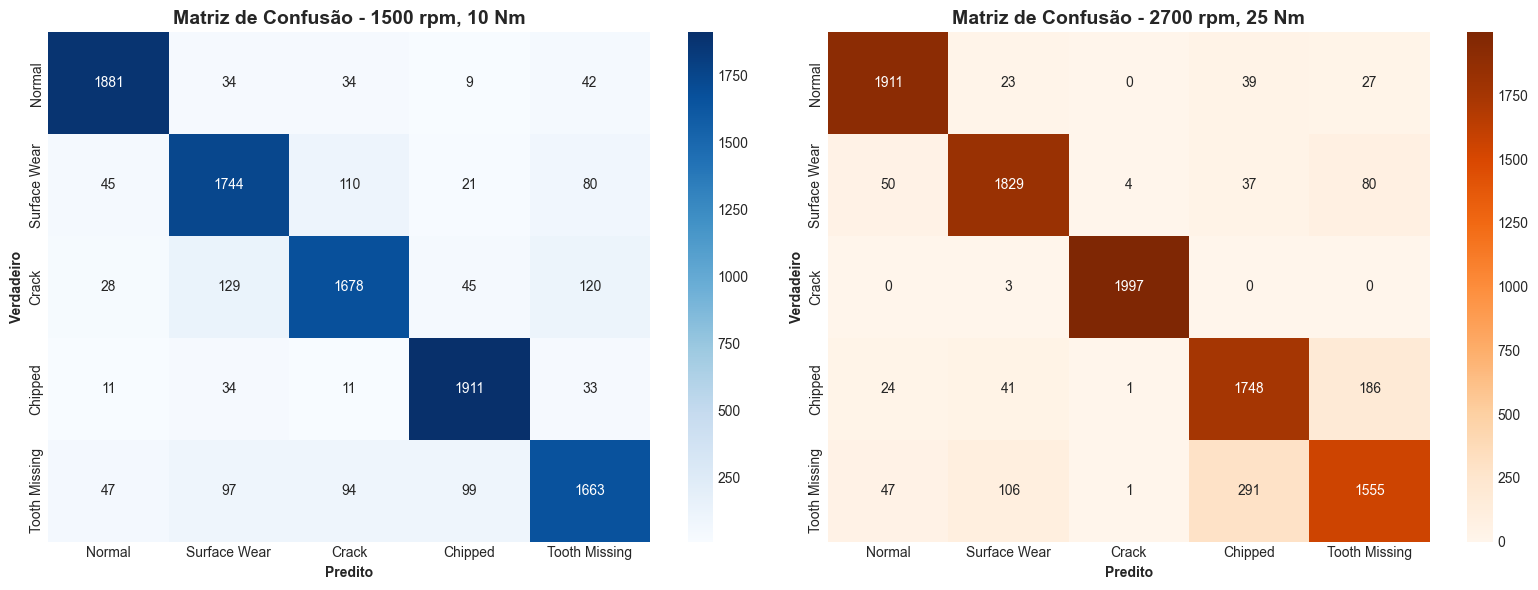

In [55]:
# Matriz de confusão - Condição 1
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Condição 1
cm_1500 = confusion_matrix(y_test_1500, y_pred_1500)
sns.heatmap(cm_1500, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[class_names[i] for i in range(5)],
            yticklabels=[class_names[i] for i in range(5)],
            ax=axes[0])
axes[0].set_title('Matriz de Confusão - 1500 rpm, 10 Nm', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Verdadeiro', fontweight='bold')
axes[0].set_xlabel('Predito', fontweight='bold')

# Condição 2
cm_2700 = confusion_matrix(y_test_2700, y_pred_2700)
sns.heatmap(cm_2700, annot=True, fmt='d', cmap='Oranges',
            xticklabels=[class_names[i] for i in range(5)],
            yticklabels=[class_names[i] for i in range(5)],
            ax=axes[1])
axes[1].set_title('Matriz de Confusão - 2700 rpm, 25 Nm', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Verdadeiro', fontweight='bold')
axes[1].set_xlabel('Predito', fontweight='bold')

plt.tight_layout()
plt.show()

In [56]:
# Relatório de classificação
print("="*70)
print("RELATÓRIO DE CLASSIFICAÇÃO - CONDIÇÃO 1 (1500 rpm, 10 Nm)")
print("="*70)
print(classification_report(y_test_1500, y_pred_1500, 
                           target_names=[class_names[i] for i in range(5)]))

print("\n" + "="*70)
print("RELATÓRIO DE CLASSIFICAÇÃO - CONDIÇÃO 2 (2700 rpm, 25 Nm)")
print("="*70)
print(classification_report(y_test_2700, y_pred_2700,
                           target_names=[class_names[i] for i in range(5)]))

RELATÓRIO DE CLASSIFICAÇÃO - CONDIÇÃO 1 (1500 rpm, 10 Nm)


               precision    recall  f1-score   support

       Normal       0.93      0.94      0.94      2000
 Surface Wear       0.86      0.87      0.86      2000
        Crack       0.87      0.84      0.85      2000
      Chipped       0.92      0.96      0.94      2000
Tooth Missing       0.86      0.83      0.84      2000

     accuracy                           0.89     10000
    macro avg       0.89      0.89      0.89     10000
 weighted avg       0.89      0.89      0.89     10000


RELATÓRIO DE CLASSIFICAÇÃO - CONDIÇÃO 2 (2700 rpm, 25 Nm)
               precision    recall  f1-score   support

       Normal       0.94      0.96      0.95      2000
 Surface Wear       0.91      0.91      0.91      2000
        Crack       1.00      1.00      1.00      2000
      Chipped       0.83      0.87      0.85      2000
Tooth Missing       0.84      0.78      0.81      2000

     accuracy                           0.90     10000
    macro avg       0.90      0.90      0.90     10000
 

## 12. Importância das Features

1500: 313 313
2700: 313 313


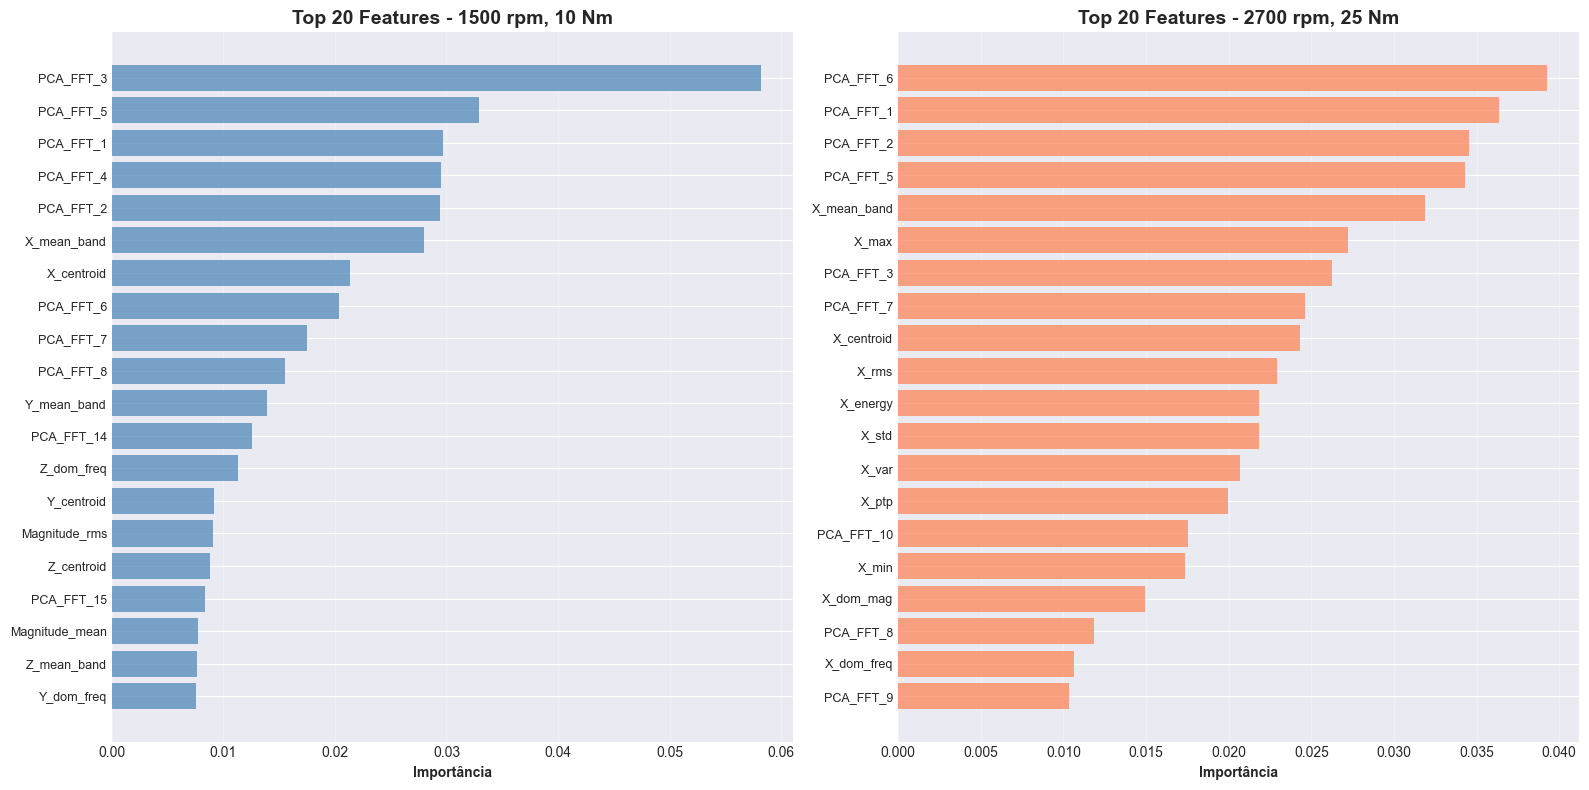

In [57]:
# Importância das features - Condição 1
importances_1500 = best_clf_1500.feature_importances_
indices_1500 = np.argsort(importances_1500)[-20:]  # Top 20 features

# Importância das features - Condição 2
importances_2700 = best_clf_2700.feature_importances_
indices_2700 = np.argsort(importances_2700)[-20:]  # Top 20 features

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Condição 1
axes[0].barh(range(20), importances_1500[indices_1500], color='steelblue', alpha=0.7)
axes[0].set_yticks(range(20))
axes[0].set_yticklabels([feature_names_1500[i] for i in indices_1500], fontsize=9)
axes[0].set_xlabel('Importância', fontweight='bold')
axes[0].set_title('Top 20 Features - 1500 rpm, 10 Nm', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Condição 2
axes[1].barh(range(20), importances_2700[indices_2700], color='coral', alpha=0.7)
axes[1].set_yticks(range(20))
axes[1].set_yticklabels([feature_names_2700[i] for i in indices_2700], fontsize=9)
axes[1].set_xlabel('Importância', fontweight='bold')
axes[1].set_title('Top 20 Features - 2700 rpm, 25 Nm', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

print("1500:", len(importances_1500), len(feature_names_1500))
print("2700:", len(importances_2700), len(feature_names_2700))

plt.tight_layout()
plt.show()

## 13. Função para Predição em Novos Dados

In [60]:
def predict_fault(x_signal, y_signal, z_signal, condition='1500'):
    """
    Prediz a condição da engrenagem a partir dos sinais de vibração

    Parameters:
    -----------
    x_signal : array-like
        Sinal de vibração no eixo X
    y_signal : array-like
        Sinal de vibração no eixo Y
    z_signal : array-like
        Sinal de vibração no eixo Z
    condition : str
        Condição operacional ('1500' ou '2700')

    Returns:
    --------
    tuple : (classe_predita, nome_classe, probabilidades)
    """
    # Features base (72)
    base_features = np.array(extract_all_features(x_signal, y_signal, z_signal)).reshape(1, -1)

    # Features FFT para PCA (mesma lógica do treino)
    fft_features = fft_xyz_features(x_signal, y_signal, z_signal).reshape(1, -1)

    # Selecionar pipeline da condição
    if condition == '1500':
        fft_features_scaled = fft_scaler_1500.transform(fft_features)
        fft_features_pca = pca_1500.transform(fft_features_scaled)
        features_full = np.hstack([base_features, fft_features_pca])
        features_scaled = scaler_1500.transform(features_full)
        prediction = best_clf_1500.predict(features_scaled)[0]
        probabilities = best_clf_1500.predict_proba(features_scaled)[0]
    elif condition == '2700':
        fft_features_scaled = fft_scaler_2700.transform(fft_features)
        fft_features_pca = pca_2700.transform(fft_features_scaled)
        features_full = np.hstack([base_features, fft_features_pca])
        features_scaled = scaler_2700.transform(features_full)
        prediction = best_clf_2700.predict(features_scaled)[0]
        probabilities = best_clf_2700.predict_proba(features_scaled)[0]
    else:
        raise ValueError("condition deve ser '1500' ou '2700'")

    return prediction, class_names[prediction], probabilities


# Testar a função com uma amostra
sample_idx = 100

print("Testando função de predição...\n")

# Predição para Condição 1
pred_class, pred_name, probs = predict_fault(
    x_1500[sample_idx], y_1500[sample_idx], z_1500[sample_idx], '1500'
)

print(f"Condição 1 (1500 rpm) - Amostra {sample_idx}:")
print(f"  Verdadeiro: {class_names[gt_1500[sample_idx]]}")
print(f"  Predito: {pred_name}")
print(f"  Probabilidades:")
for i, prob in enumerate(probs):
    print(f"    {class_names[i]}: {prob:.4f}")

# Predição para Condição 2
pred_class, pred_name, probs = predict_fault(
    x_2700[sample_idx], y_2700[sample_idx], z_2700[sample_idx], '2700'
)

print(f"\nCondição 2 (2700 rpm) - Amostra {sample_idx}:")
print(f"  Verdadeiro: {class_names[gt_2700[sample_idx]]}")
print(f"  Predito: {pred_name}")
print(f"  Probabilidades:")
for i, prob in enumerate(probs):
    print(f"    {class_names[i]}: {prob:.4f}")

print("\n✓ Função de predição funcionando corretamente!")

Testando função de predição...

Condição 1 (1500 rpm) - Amostra 100:
  Verdadeiro: Surface Wear
  Predito: Surface Wear
  Probabilidades:
    Normal: 0.0400
    Surface Wear: 0.7650
    Crack: 0.0650
    Chipped: 0.0400
    Tooth Missing: 0.0900

Condição 2 (2700 rpm) - Amostra 100:
  Verdadeiro: Normal
  Predito: Normal
  Probabilidades:
    Normal: 0.5650
    Surface Wear: 0.0800
    Crack: 0.0000
    Chipped: 0.2400
    Tooth Missing: 0.1150

✓ Função de predição funcionando corretamente!


## 14. Salvar Modelos Treinados

In [61]:
import pickle

# Salvar modelos e scalers
with open('model_1500.pkl', 'wb') as f:
    pickle.dump(best_clf_1500, f)

with open('model_2700.pkl', 'wb') as f:
    pickle.dump(best_clf_2700, f)

with open('scaler_1500.pkl', 'wb') as f:
    pickle.dump(scaler_1500, f)

with open('scaler_2700.pkl', 'wb') as f:
    pickle.dump(scaler_2700, f)

print("✓ Modelos salvos com sucesso!")
print("\nArquivos gerados:")
print("  - model_1500.pkl")
print("  - model_2700.pkl")
print("  - scaler_1500.pkl")
print("  - scaler_2700.pkl")

✓ Modelos salvos com sucesso!

Arquivos gerados:
  - model_1500.pkl
  - model_2700.pkl
  - scaler_1500.pkl
  - scaler_2700.pkl


## 15. Resumo e Conclusões

In [63]:
print("="*70)
print("RESUMO DO PROJETO ICPHM23 DATA CHALLENGE")
print("="*70)

print("\n1. DADOS ANALISADOS:")
print(f"   - Condição 1 (1500 rpm, 10 Nm): {len(gt_1500)} amostras")
print(f"   - Condição 2 (2700 rpm, 25 Nm): {len(gt_2700)} amostras")
print(f"   - Classes: 5 (Normal, Surface Wear, Crack, Chipped, Tooth Missing)")
print(f"   - Sinais: 3 eixos (X, Y, Z) + Magnitude combinada")
print(f"   - Features extraídas: 72 por amostra")

print("\n2. METODOLOGIA:")
print("   - Extração de features estatísticas (tempo e frequência)")
print("   - Normalização com StandardScaler")
print("   - Validação cruzada estratificada (5-fold)")
print("   - 5 algoritmos de ML testados")

print("\n3. MELHORES RESULTADOS:")
print(f"\n   Condição 1 (1500 rpm):")
print(f"   - Melhor modelo: {best_model_1500}")
print(f"   - Accuracy: {results_1500[best_model_1500]['accuracy']:.4f}")
print(f"   - F1-Score: {results_1500[best_model_1500]['f1']:.4f}")

print(f"\n   Condição 2 (2700 rpm):")
print(f"   - Melhor modelo: {best_model_2700}")
print(f"   - Accuracy: {results_2700[best_model_2700]['accuracy']:.4f}")
print(f"   - F1-Score: {results_2700[best_model_2700]['f1']:.4f}")

print("\n4. ENTREGAS:")
print("   ✓ Análise exploratória completa")
print("   ✓ Visualizações (tempo e frequência)")
print("   ✓ Múltiplos modelos avaliados")
print("   ✓ Validação cruzada de 5-fold")
print("   ✓ Matriz de confusão e métricas detalhadas")
print("   ✓ Análise de importância de features")
print("   ✓ Modelos treinados e salvos")
print("   ✓ Função de predição para novos dados")

print("\n" + "="*70)
print("PROJETO CONCLUÍDO COM SUCESSO!")
print("="*70)

RESUMO DO PROJETO ICPHM23 DATA CHALLENGE

1. DADOS ANALISADOS:
   - Condição 1 (1500 rpm, 10 Nm): 50000 amostras
   - Condição 2 (2700 rpm, 25 Nm): 50000 amostras
   - Classes: 5 (Normal, Surface Wear, Crack, Chipped, Tooth Missing)
   - Sinais: 3 eixos (X, Y, Z) + Magnitude combinada
   - Features extraídas: 72 por amostra

2. METODOLOGIA:
   - Extração de features estatísticas (tempo e frequência)
   - Normalização com StandardScaler
   - Validação cruzada estratificada (5-fold)
   - 5 algoritmos de ML testados

3. MELHORES RESULTADOS:

   Condição 1 (1500 rpm):
   - Melhor modelo: SVM
   - Accuracy: 0.9751
   - F1-Score: 0.9752

   Condição 2 (2700 rpm):
   - Melhor modelo: SVM
   - Accuracy: 0.9703
   - F1-Score: 0.9703

4. ENTREGAS:
   ✓ Análise exploratória completa
   ✓ Visualizações (tempo e frequência)
   ✓ Múltiplos modelos avaliados
   ✓ Validação cruzada de 5-fold
   ✓ Matriz de confusão e métricas detalhadas
   ✓ Análise de importância de features
   ✓ Modelos treinados e 